In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
fpga = {}
fpga['DSP48E'] = 5520
fpga['BRAM_18K'] = 4320
fpga['FF'] = 1326720
fpga['LUT'] = 663360

In [3]:
MODEL = 'LSTMvsTCN'
MODELLSTM = f"lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix"
MODELGRU = "tcn_BatchNormFalse_MaskingFalse_08072022_02.28.45_normalMatrix"

INTBIT1 = 8
INTBIT2 = 12

fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls/"

files_loc_lstm = f"{fld}/{MODELLSTM}/reports/*.txt"
files_loc_gru = f"{fld}/{MODELGRU}/reports/*.txt"

In [4]:
plot_loc = f'model_plots/{MODEL}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [5]:
files = glob(files_loc_lstm) + glob(files_loc_gru)

In [6]:
files

['/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_6.2_reuse_10_Resource_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_28.8_reuse_50_Resource_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_20.2_reuse_10_Resource_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_16.2_reuse_1_Resource_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_10.8_reuse_1_Resource_Static_BigTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls//lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/reports/model_26.8_reuse_5_Latency_S

In [7]:
base_dict = {
    'name':'',
    'file': '',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'INT_min': -1,
    'INT_max': -1,
    'ap_tot': -1,
    'ap_frac': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1,
    'model': '',
    'static': 1,
    'mac_max': -1,
    'mac_min': -1,
    'npar': -1
}

In [8]:
dicts = []

lat_unit = 'us'

for ff in files:
    with open(ff, 'r') as hf:

        this_dict = copy.deepcopy(base_dict)
        this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
        this_dict['file'] = ff
        
        this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
        this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

        modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')
        
        if 'NonStatic' in ff: this_dict['static'] = 0

        this_dict['ap_tot'] = int(modes[0])
        this_dict['ap_int'] = int(modes[1])
        this_dict['ap_frac'] = this_dict['ap_tot'] - this_dict['ap_int']
        this_dict['ap_quant'] = 'std' if len(modes) < 3 else modes[2]
        this_dict['ap_over'] = 'std' if len(modes) < 3 else modes[3]
        if 'tcn' in ff.lower():
            this_dict['model'] = 'tcn'
        elif 'gru' in ff.lower():
            this_dict['model'] = 'gru'
        elif 'lstm' in ff.lower():
            this_dict['model'] = 'lstm'

        # this_dict['npar'] = n_params_gru if 'GRU' in ff or 'gru' in ff else n_params_lstm

        for line in hf:
            if 'function' in line or 'none' in line or 'dataflow' in line:
                if '_' in line: continue
                
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]

                this_dict['LAT_min'] = float(sline[3])
                this_dict['LAT_max'] = float(sline[6])
                
                this_dict['INT_min'] = float(sline[9])
                this_dict['INT_max'] = float(sline[10])
                
                this_dict['mac_max'] = float(this_dict['npar'])/float(this_dict['INT_max'])
                this_dict['mac_min'] = float(this_dict['npar'])/float(this_dict['INT_min'])
                
                # if sline[4] != sline[7]:
                #     print(sline[4], sline[7])
                #     break
                
                if 'ms' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                if 'ns' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e-3
                    
                if 'ms' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                if 'ns' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e-3
    
                # if 'none' in lat_unit:
                #     lat_unit = sline[4]
                # else:
                #     assert sline[4] == lat_unit

            if 'Total' in line and this_dict['FF'] == -1:
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]
                
                this_dict['BRAM_18K']  = int( sline[2] )
                this_dict['DSP48E']    = int( sline[3] )
                this_dict['FF']        = int( sline[4] )
                this_dict['LUT']       = int( sline[5] )
                this_dict['URAM']      = int( sline[6] )
            
            if 'KERAS_AUC' in line:
                sline = line.split()
                this_dict['keras_auc'] = float(sline[1])

            if 'HLS_AUC' in line:
                sline = line.split()
                this_dict['hls_auc'] = float(sline[1])

        # this_dict['rel_auc'] = abs( this_dict['keras_auc'] - this_dict['hls_auc'] ) / this_dict['keras_auc']
        this_dict['rel_auc'] = abs( this_dict['hls_auc'] ) / this_dict['keras_auc']
        dicts.append(this_dict)

In [9]:
tot_dict = copy.deepcopy(base_dict)

for kk in tot_dict:
    tot_dict[kk] = [ dd[kk] for dd in dicts]

In [10]:
tot_dict

{'name': ['model_6.2_reuse_10_Resource_Static_BigTable',
  'model_28.8_reuse_50_Resource_Static_BigTable',
  'model_20.2_reuse_10_Resource_Static_BigTable',
  'model_16.2_reuse_1_Resource_Static_BigTable',
  'model_10.8_reuse_1_Resource_Static_BigTable',
  'model_26.8_reuse_5_Latency_Static_BigTable',
  'model_22.10_reuse_5_Resource_Static_BigTable',
  'model_18.12_reuse_50_Resource_Static_BigTable',
  'model_12.4_reuse_10_Latency_Static_BigTable',
  'model_20.10_reuse_10_Resource_Static_BigTable',
  'model_16.14_reuse_1_Resource_Static_BigTable',
  'model_32.12_reuse_100_Resource_Static_BigTable',
  'model_20.10_reuse_100_Resource_Static_BigTable',
  'model_6.4_reuse_10_Resource_Static_BigTable',
  'model_10.4_reuse_5_Latency_Static_BigTable',
  'model_16.10_reuse_1_Latency_Static_BigTable',
  'model_28.14_reuse_100_Resource_Static_BigTable',
  'model_20.6_reuse_100_Latency_Static_BigTable',
  'model_16.10_reuse_50_Resource_Static_BigTable',
  'model_16.10_reuse_5_Resource_Static_BigT

In [11]:
import pandas as pd

In [12]:
pd_dict = pd.DataFrame.from_dict(tot_dict)

In [13]:
pd_dict.head()

,name,file,BRAM_18K,DSP48E,FF,LUT,URAM,LAT_min,LAT_max,INT_min,...,strategy,reuse,keras_auc,hls_auc,rel_auc,model,static,mac_max,mac_min,npar
0,model_6.2_reuse_10_Resource_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,86,10,4364,22303,0,1.670,2.945,301.0,...,Resource,10,0.967146,0.505767,0.522947,lstm,1,-0.001808,-0.003322,-1
1,model_28.8_reuse_50_Resource_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,266,178,19547,39417,0,4.485,5.760,781.0,...,Resource,50,0.967146,0.953929,0.986333,lstm,1,-0.000968,-0.001280,-1
2,model_20.2_reuse_10_Resource_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,229,212,13772,32427,0,1.670,2.945,301.0,...,Resource,10,0.967146,0.498905,0.515853,lstm,1,-0.001808,-0.003322,-1
3,model_16.2_reuse_1_Resource_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,321,426,15652,61465,0,1.120,2.395,205.0,...,Resource,1,0.967146,0.498202,0.515126,lstm,1,-0.002188,-0.004878,-1
4,model_10.8_reuse_1_Resource_Static_BigTable,/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...,197,10,9971,58985,0,1.120,2.395,205.0,...,Resource,1,0.967146,0.624484,0.645697,lstm,1,-0.002188,-0.004878,-1


In [14]:
def get_plot(st, reu, apint, var, model, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ].ap_frac.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [15]:
def get_plot_tot(st, reu, apint, var, model, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ].ap_tot.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [16]:
get_plot('Resource', 5, 6, 'rel_auc', model='lstm')

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
 array([0.55468337, 0.70505955, 0.59050879, 0.60676706, 0.59951678,
        0.60001801, 0.59960996, 0.59978036, 0.59965322, 0.59968015])]

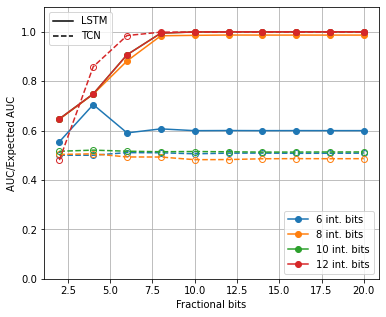

In [32]:
strat = 'Latency'

vars = ['rel_auc']
var_labs = [ r'AUC/Expected AUC']
reuse_to_plot=1

marker=['o', 'v', 's', '*', 'D', '^', 'P']

for reuse in [reuse_to_plot]:
    
    for ivv,vv in enumerate(vars):
        

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        
        # myplot = get_plot(strat, reuse, 4, vv, model='lstm')
        # ax.plot( myplot[0],myplot[1], 'o-', color='C0', label='4 int. bits' )
        # # ax.set_xticks(np.arange(min(myplot[0]), max(myplot[0])+1, 4.0))
        # print(myplot[0])
        
#         myplot = get_plot(strat, reuse, 4, vv, model='tcn')
#         ax.plot( myplot[0],myplot[1], 'o--', color='C0', fillstyle='none' )
        

        for iib,ib in enumerate([6, 8, 10, 12]):
            
            for md in [ 
                       ['lstm', 'o-', ib, f'{ib} int. bits', 'full'], 
                       ['tcn', 'o--', ib, None, 'none']
                        ]:
                
                myplot = get_plot(strat, reuse, md[2], vv, md[0], 22)
                ax.plot( myplot[0],myplot[1], md[1], color=f'C{iib}', label=md[3], fillstyle=md[4] )
        
        
        # plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        ax.legend(frameon=True, loc='lower right')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional bits')
        if 'LAT' in vv:
            ax.set_ylabel(var_labs[ivv]+f' ({lat_unit})')
        else:
            ax.set_ylabel(var_labs[ivv])
            

        lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                     mpl.lines.Line2D([0], [0], ls='--', color='black')]
        
        leg = mpl.legend.Legend(ax, lines, labels=['LSTM', 'TCN'],
            loc='upper left', frameon=True)
        ax.add_artist(leg)

        plt.ylim(0,1.1)
        # plt.title(model_name, loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

In [33]:
get_plot_tot('Resource', 100, 14, 'DSP48E', 'tcn', 30)

[array([16, 18, 20, 22, 24, 26, 28, 30]),
 array([-1, -1, -1, -1, -1, -1, -1, -1])]

In [34]:
reuses = [1, 5, 10, 50]
# reuses = [1, 5, 10, 50, 100]
reuses_labels = reuses

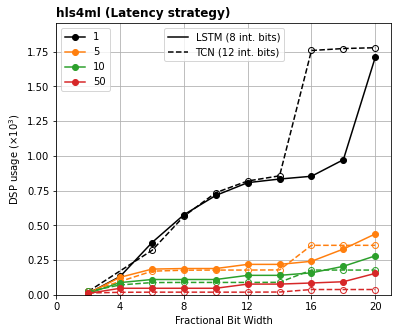

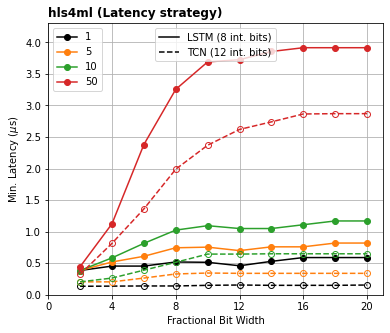

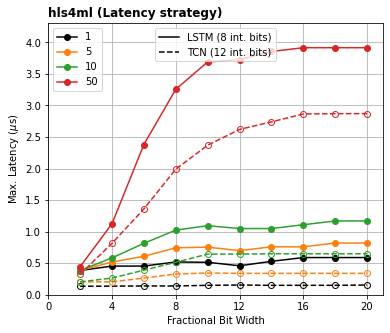

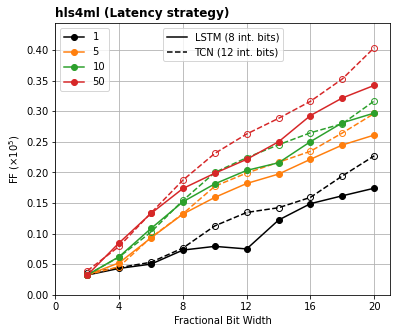

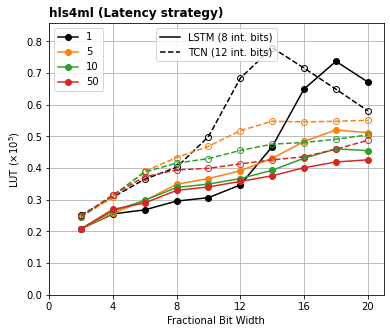

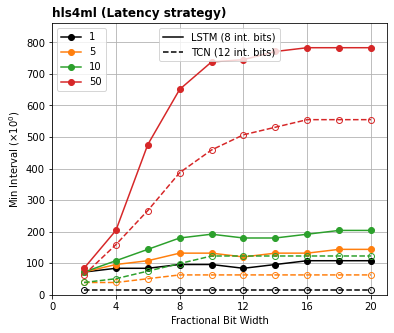

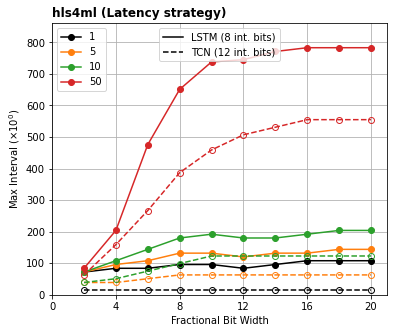

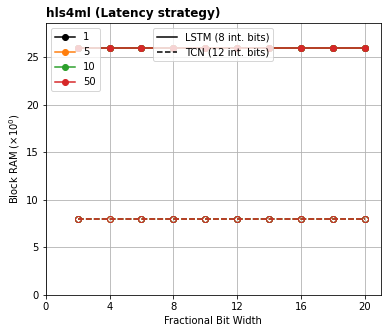

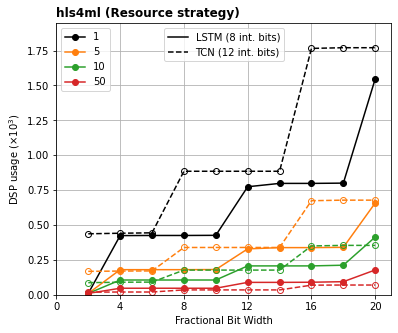

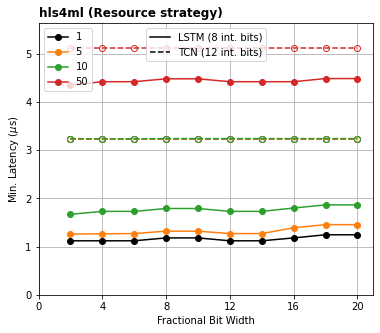

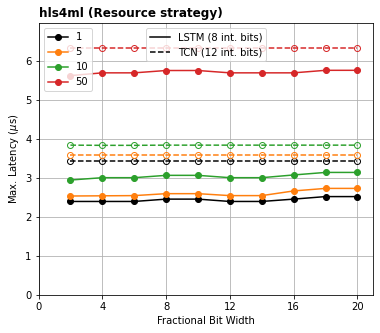

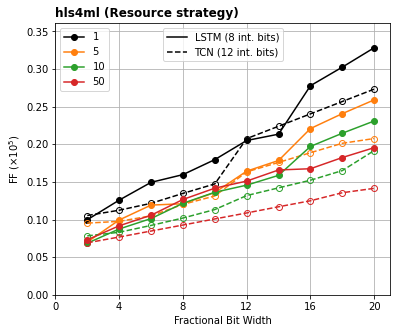

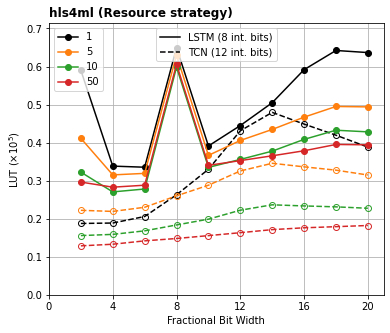

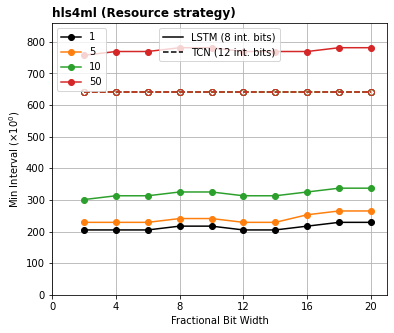

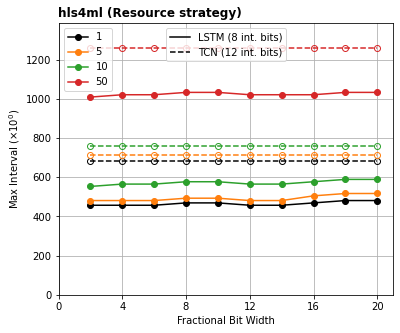

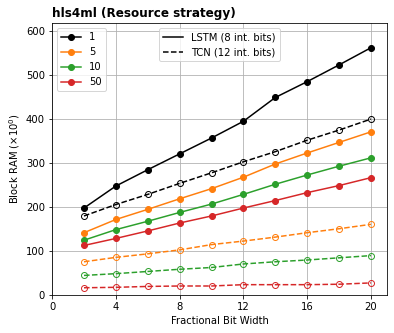

In [35]:
vars = ['DSP48E', f'LAT_min', f'LAT_max', 'FF', 'LUT', 'INT_min', 'INT_max', 'BRAM_18K']
var_labs = ['DSP usage', f'Min. Latency', f'Max. Latency', 'FF', 'LUT', 
            'Min Interval', 'Max Interval', 'Block RAM']
facts = [3, 0, 0, 5, 5, 0, 0, 0, 0, 3]

maxx = 20
    
for strat in ['Latency', 'Resource']:
    
    for ivv,vv in enumerate(vars):

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        # plt.xlim(9,31)

        # for ire,reuse in enumerate([50, 100, 200, 500, 1000, 2000]):
        # for ire,reuse in enumerate([50, 100, 200, 1000]):
        pmax = 0
        pmin = 0
        for ire,reuse in enumerate(reuses):

            col=f'C{ire}'
            if reuse == 1:
                col = 'black'

                
            for md in [ 
                       ['lstm', 'o-', INTBIT1, reuses_labels[ire], 'full'], 
                       ['tcn', 'o--', INTBIT2, None, 'none']
                        ]:
                
                myplot = get_plot(strat, reuse, md[2], vv, md[0], maxx)
                ax.plot( myplot[0][myplot[1]>0],myplot[1][myplot[1]>0]/(10**facts[ivv]), md[1], color=col, label=md[3], fillstyle=md[4] )
                if max(myplot[1][myplot[1]>0]/(10**facts[ivv])) > pmax:
                    pmax = max(myplot[1][myplot[1]>0]/(10**facts[ivv]))
                if min(myplot[1][myplot[1]>0]/(10**facts[ivv])) < pmin:
                    pmin = min(myplot[1][myplot[1]>0]/(10**facts[ivv]))


        ax.set_xticks(np.arange(0, maxx+1, 4.0))
        ax.set_xlim(0,maxx+1)
        ax.set_ylim(pmin, pmax*1.1)

        # ax.legend(title=f'{INTBIT} int. bits'+'\n'+f'Dense R = {dense_reuse}', frameon=True,
        #           loc='upper left')
        ax.legend(frameon=True,
                  loc='upper left')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional Bit Width')
        if 'LAT' in vv:
            # ax.set_yscale('log')
            unit = lat_unit.replace('u', '$\\mu$')
            ax.set_ylabel(var_labs[ivv] +f' ({unit})')
        else:
            ax.set_ylabel(var_labs[ivv] +f' ($\\times 10^{str(facts[ivv])} $)')

        lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                         mpl.lines.Line2D([0], [0], ls='--', color='black')]

        leg = mpl.legend.Legend(ax, lines, labels=[f'LSTM ({INTBIT1} int. bits)', f'TCN ({INTBIT2} int. bits)'],
                loc='upper center', frameon=True)
                # bbox_to_anchor=(0.55, 1.), frameon=True)
        ax.add_artist(leg)

        # if vv in fpga:
        #     ax.plot([0,21], [fpga[vv]/(10**facts[ivv]), fpga[vv]/(10**facts[ivv])], '--', color='gray') 

        plt.title(f'hls4ml ({strat} strategy)', loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{strat}.pdf", bbox_inches='tight')
        plt.show()